In [6]:
%matplotlib widget

# 6) Reviewing IFU results

In this tutorial, we are going to explore some tools to check the measurements from the [previous tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/n_tutorial5_IFU_fitting.html#).

This tutorial can found as a script and a notebook on the [examples folder](https://github.com/Vital-Fernandez/lime/tree/master/examples/tutorials). The observation itself, you will need to download it from the [MANGA survey](https://www.sdss4.org/surveys/manga/). The galaxy we shall study is [SHOC579](https://dr17.sdss.org/marvin/galaxy/8626-12704/), a compact galaxy with an intense star forming region.

Let’s start by importing the libraries we need:

## Loading the data

In [23]:
import numpy as np
import lime
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt

Let's define the inputs and outputs paths

In [8]:
# State the data location
cfg_file = Path('../sample_data/manga.toml')
cube_file = Path('../sample_data/spectra/manga-8626-12704-LOGCUBE.fits.gz')
bands_file_0 = Path('../sample_data/SHOC579_MASK0_bands.txt')
spatial_mask_file = Path('../sample_data/SHOC579_mask.fits')
output_lines_log_file = Path('../sample_data/SHOC579_log.fits')

Now, we load the configuration file.

In [9]:
# Load the configuration file:
obs_cfg = lime.load_cfg(cfg_file)

# Observation properties
z_obj = obs_cfg['SHOC579']['redshift']

In the [4th tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/n_tutorial4_IFU_masking.html), we opened the *.fits* file using astropy functions to extract the wavelength and flux arrays, as well as, the [WCS](https://fits.gsfc.nasa.gov/fits_wcs.html). In this ocasion, we are going to use the ``lime.cube.from_file`` function to directly read the file into a ``lime.Cube``. In this case we only need to provide the observation redshift:

In [10]:
# Load the Cube
shoc579 = lime.Cube.from_file(cube_file, instrument='manga', redshift=z_obj)


/home/vital/PycharmProjects/lime/src/lime/read_fits.py:595: RuntimeWarning: invalid value encountered in sqrt
  err_cube = np.sqrt(1 / np.ma.masked_array(ivar_cube, pixel_mask_cube))
a string value was expected. [astropy.wcs.wcs]


We can visualize the fittings from the previous tutorial by including the measurements file into the ``Cube.check.cube`` ``lines_file`` argument

/home/vital/PycharmProjects/lime/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


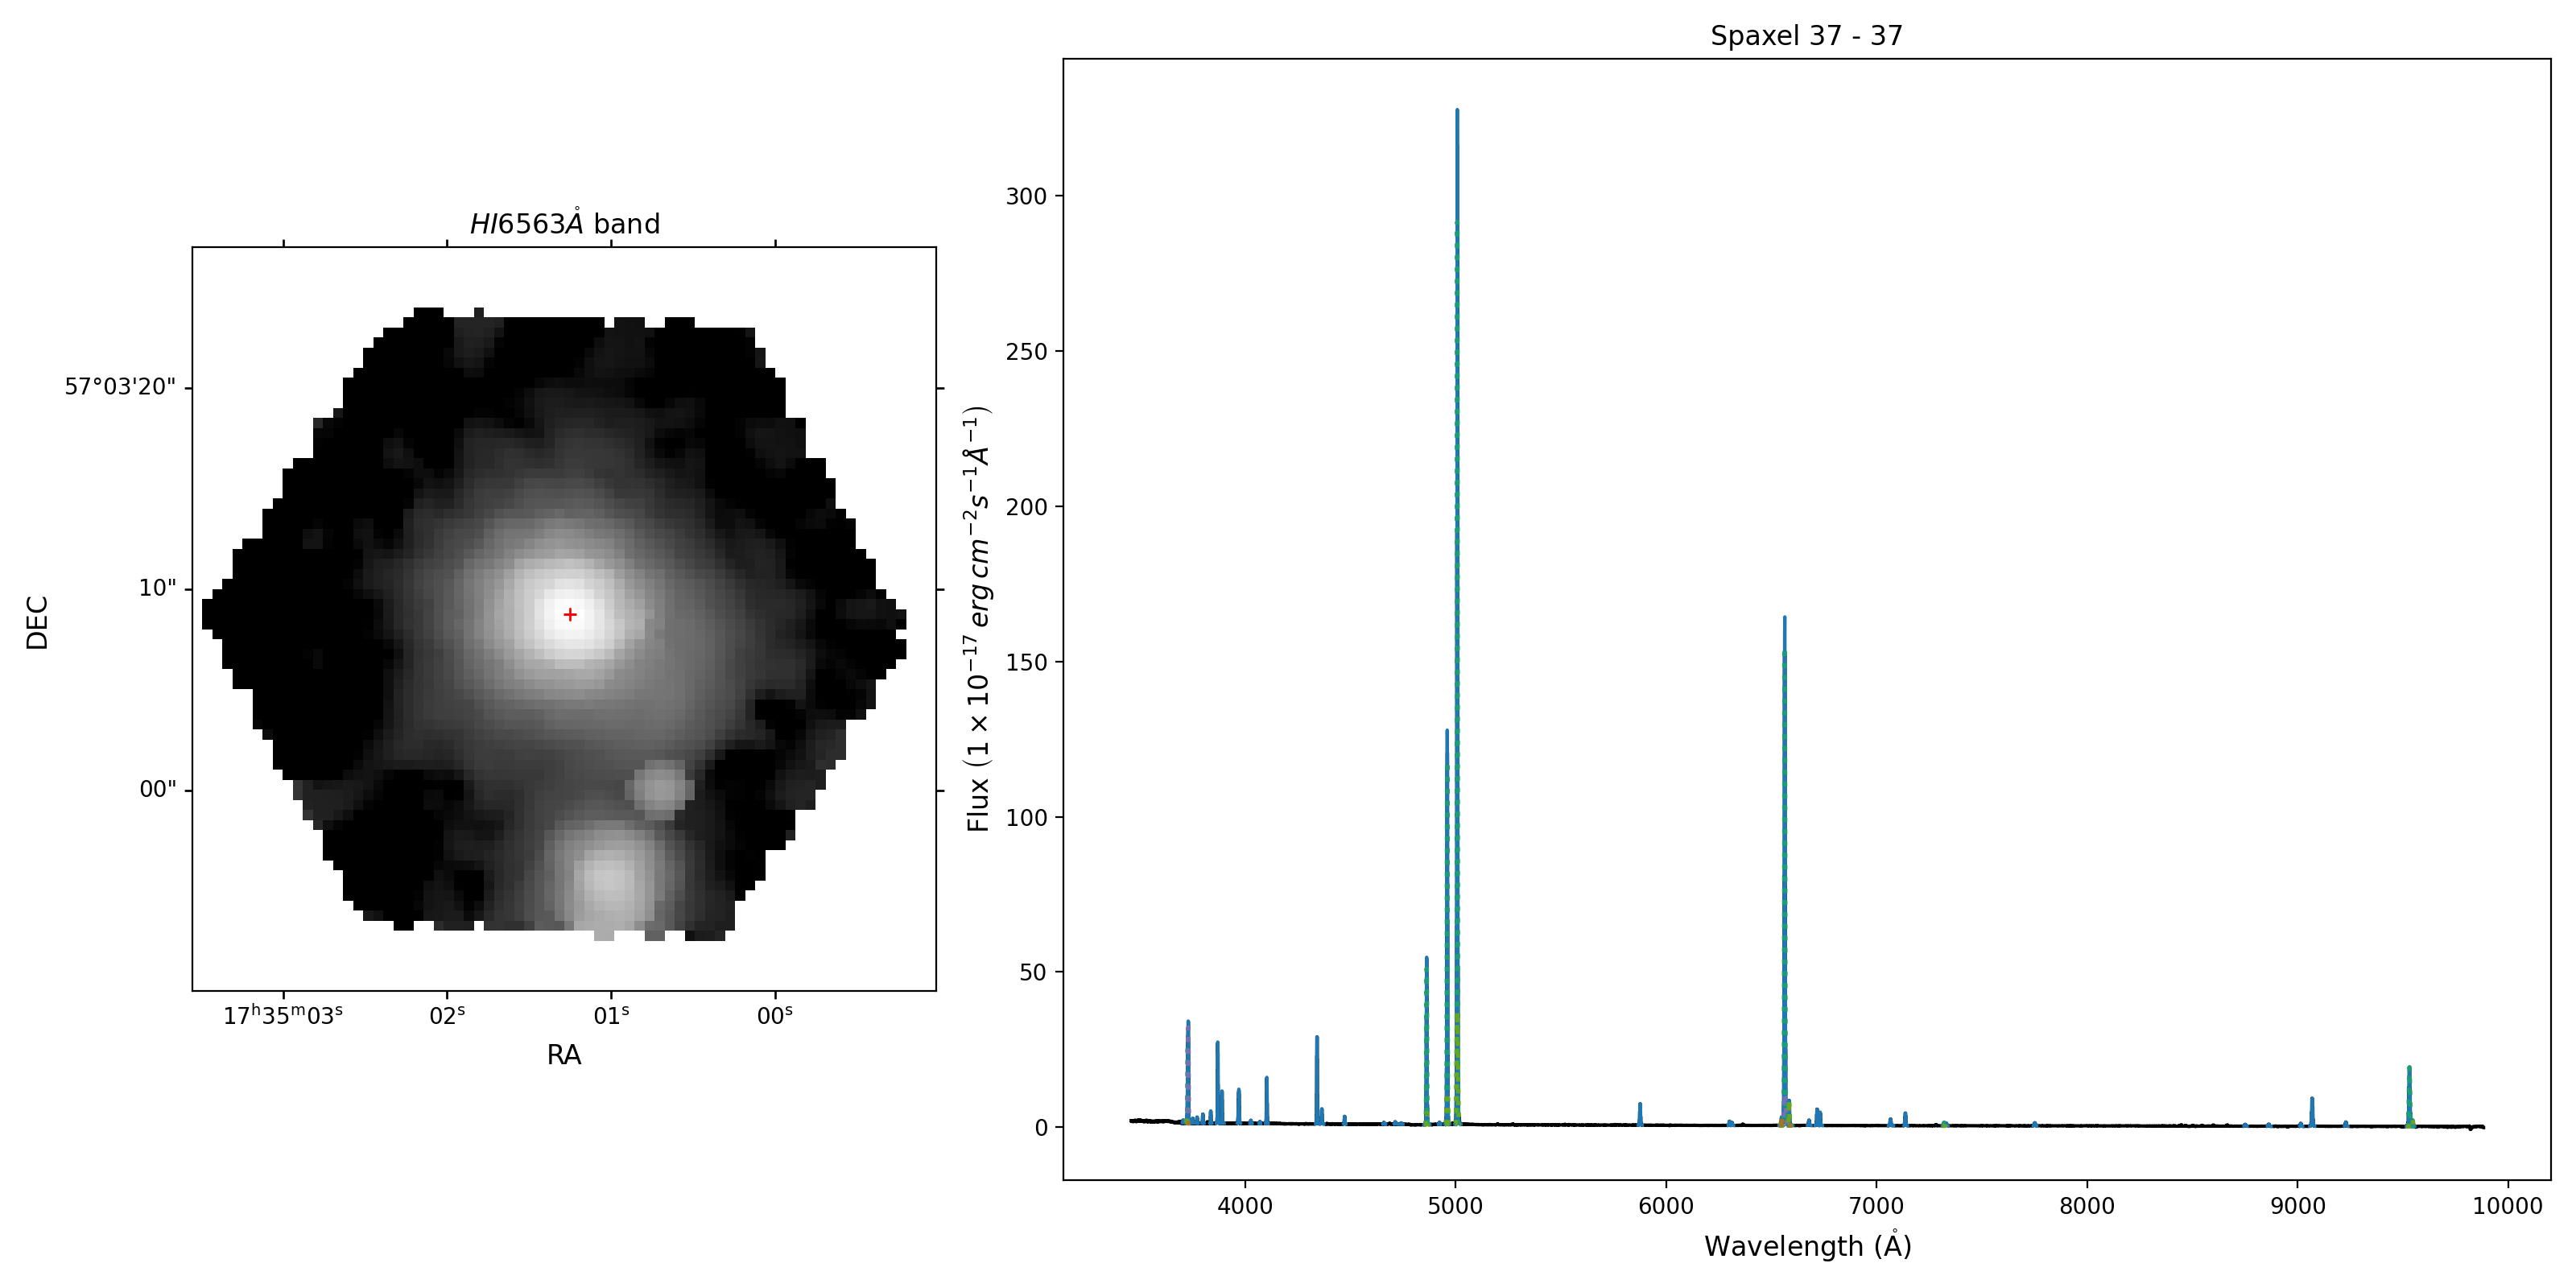

In [15]:
shoc579.check.cube('H1_6563A', lines_file=output_lines_log_file, rest_frame=True)

Additinally, you can extract individual ``lime.Spectrum`` from this cube and use the ``Spectrum.plot`` functions to review measurements from certain spaxels:

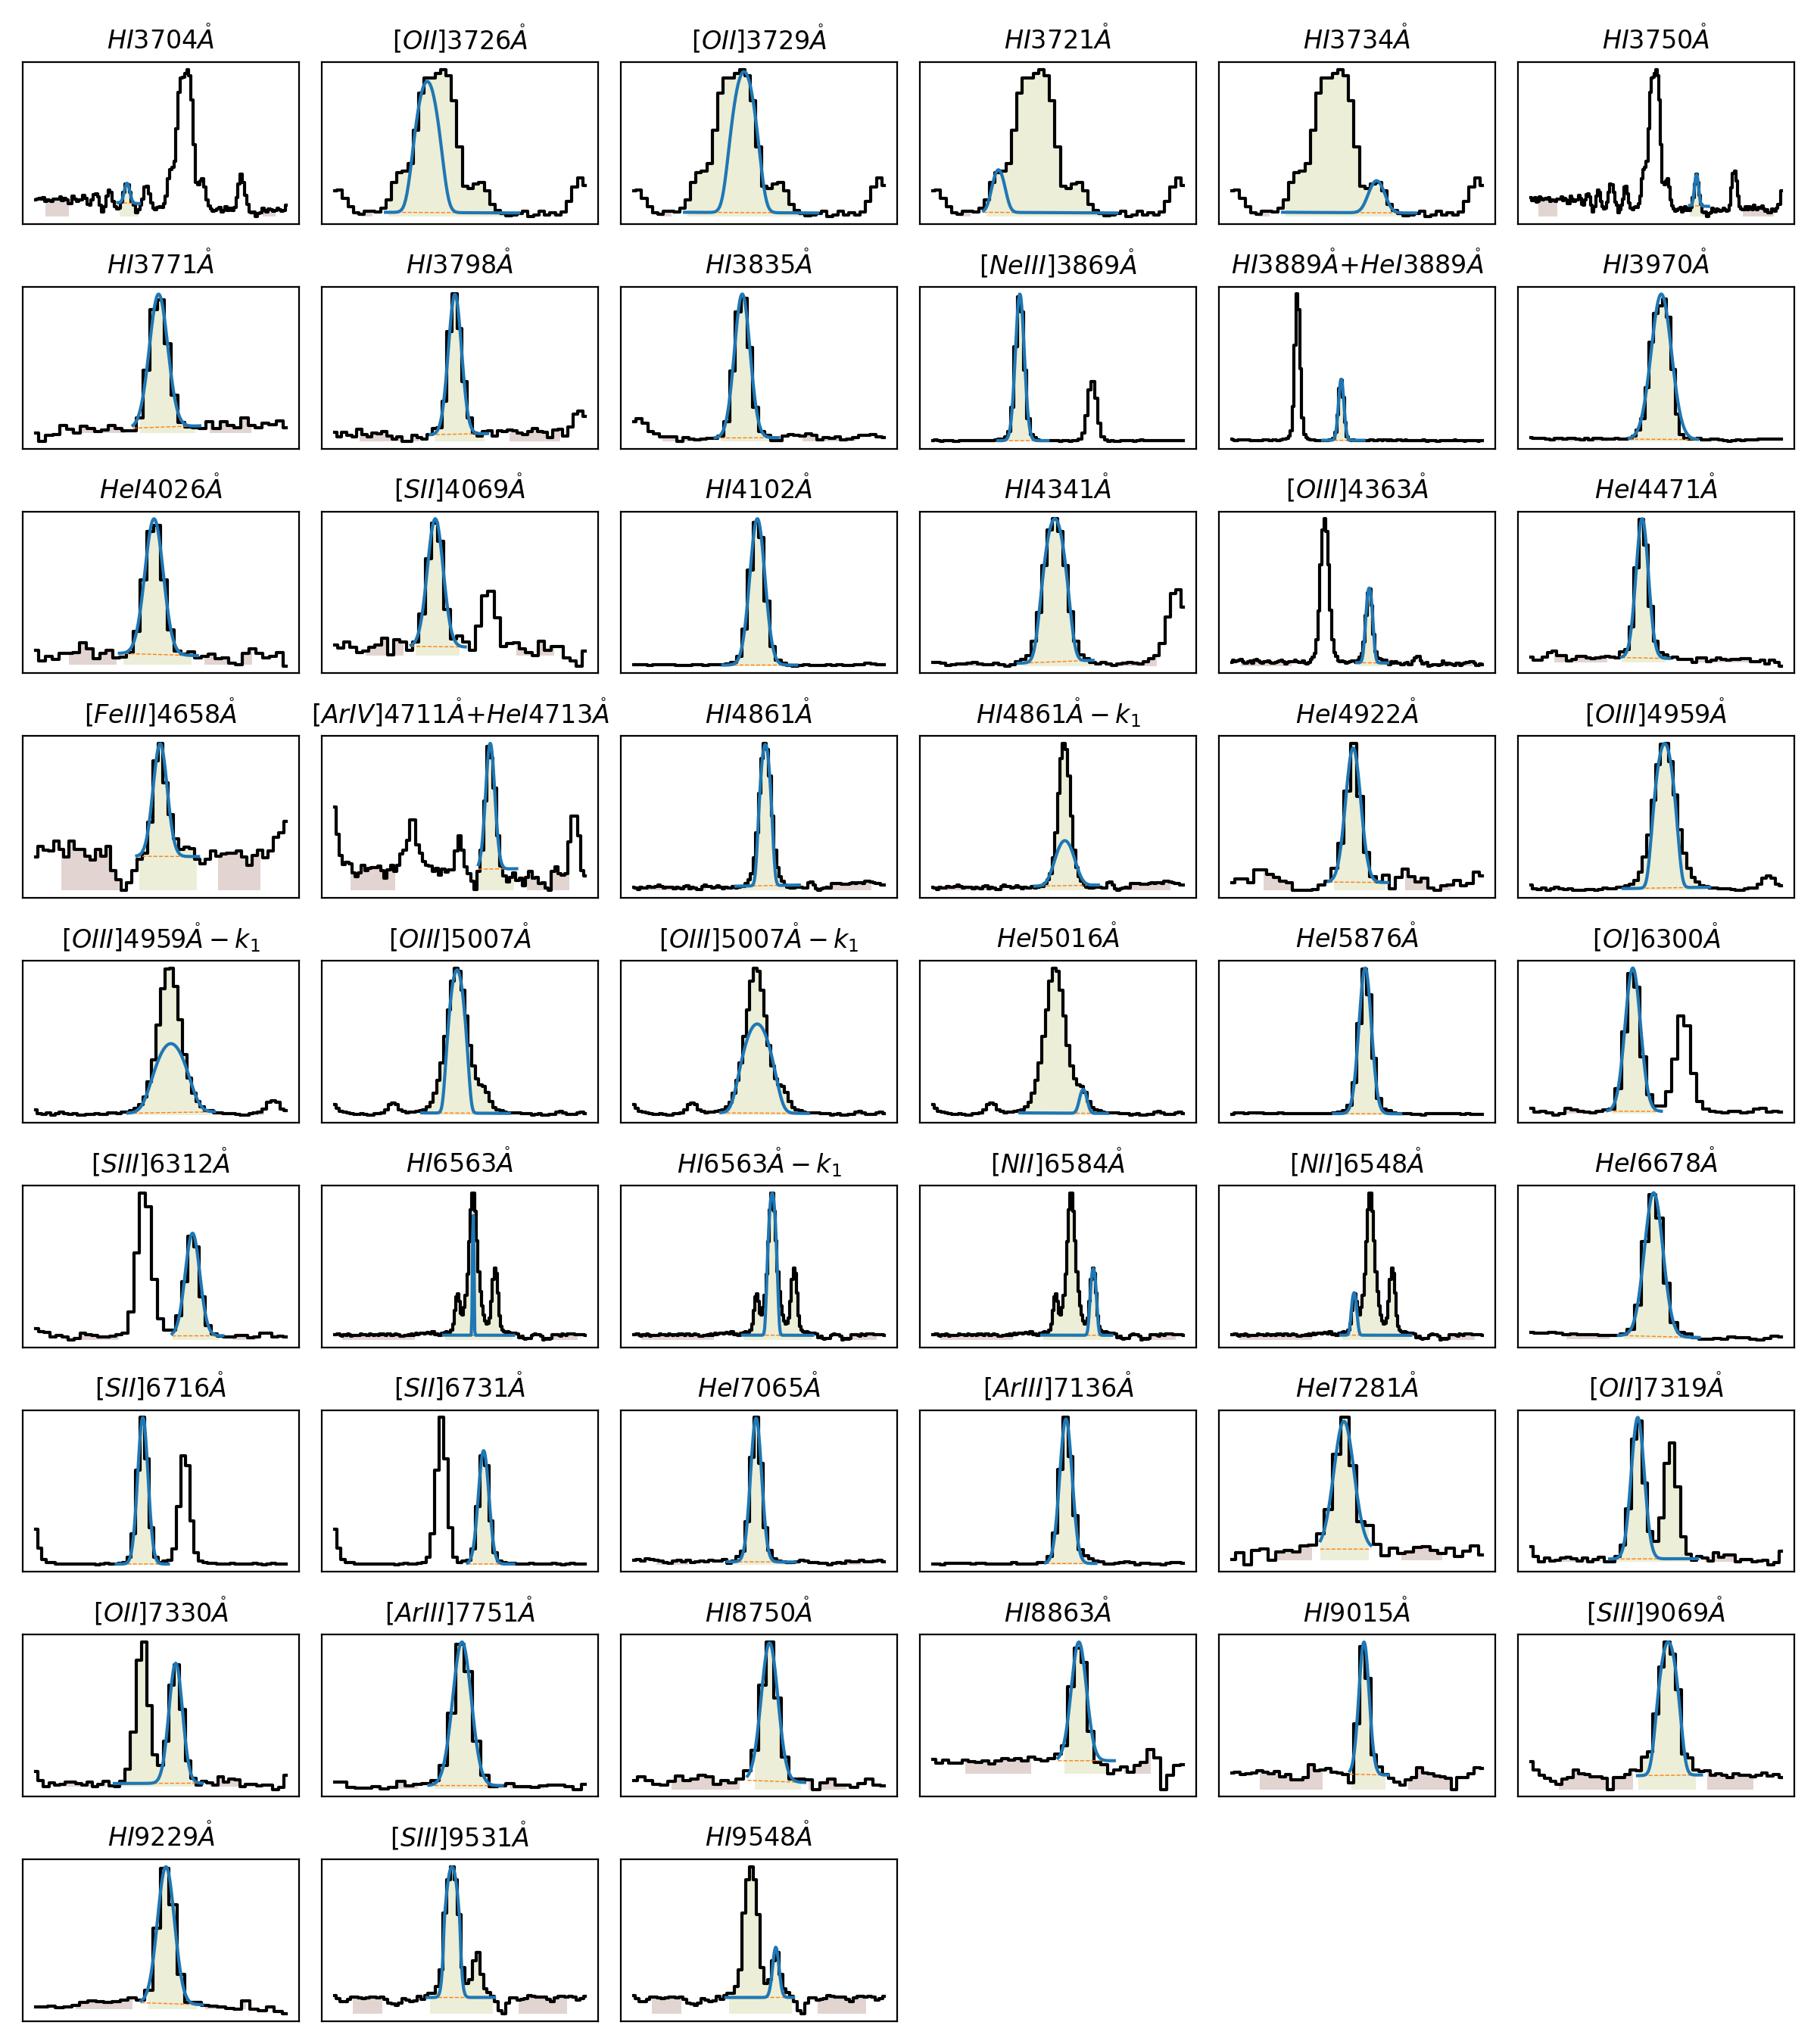

In [16]:
# Check the individual spaxel fitting configuration
spaxel = shoc579.get_spectrum(38, 35)
spaxel.load_frame(output_lines_log_file, page='38-35_LINELOG')
spaxel.plot.grid()

You can use $LiMe$ functions to extract and convert indivudal spaxels lines logs from the original *.fits* file:

In [17]:
spaxel_log_df = lime.load_frame(output_lines_log_file, page='38-35_LINELOG')
lime.save_frame('../sample_data/38-35_linelog.txt', spaxel_log_df, )

## Spatial parameter maps

To take advantage of the IFU data, you need to explore the spatial evolution of these line measurements. You can generate these maps with the ``lime.save_parameter_maps``:

In [18]:
# Export the line measurements as spatial maps:
param_list = ['intg_flux', 'intg_flux_err', 'profile_flux', 'profile_flux_err', 'v_r', 'v_r_err']
lines_list = ['H1_4861A', 'H1_6563A', 'O3_4363A', 'O3_4959A', 'O3_5007A', 'S3_6312A', 'S3_9069A', 'S3_9531A']
lime.save_parameter_maps(output_lines_log_file, '../sample_data/', param_list, lines_list,
                         mask_file=spatial_mask_file, output_file_prefix='SHOC579_', wcs=shoc579.wcs)

[==========] 100% of spaxels from file of spaxels from file (../sample_data/SHOC579_log.fits) read (227 total spaxels)


<div class="alert alert-info">

**Please remember:** The inputs and outputs of the ``lime.save_parameter_maps`` can only be *.fits* files.
    
</div>

This function produces different outputs depending on its arguments:

* The ``param_list`` argument establishes which parameters from the input ``output_lines_log_file`` will be exported into a *.fits* file. There will be *.fits* file per item on the ``param_list``. These files will be stored on the ``output_folder``  using ``output_files_prefix`` and the item name. The item name must follow the parameter notation of the [logs measurements](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html).
* The ``line_list`` arguments establishes, which line measurements are exported to the output parameter *.fits* files. Each file will have one extension per line.
* The user can specify a binary mask with the ``mask_file`` argument. By default default it will use all the masks extensions on the input *.fits* unless the user specifies certain masks with the ``mask_list`` argument.

<div class="alert alert-info">

**Please remember:** It is important to provide an input ``mask_file`` argument to make sure only spaxels with scientific data are queried on the input ``output_lines_log_file``.
    
</div>

At this point we plot some flux ratio diagnostics from theses maps. Let's define them:

In [19]:
# State line ratios for the plots
lines_ratio = {'H1': ['H1_6563A', 'H1_4861A'],
               'O3': ['O3_5007A', 'O3_4959A'],
               'S3': ['S3_9531A', 'S3_9069A']}

Since some of these lines are blended we are going to use the gaussian fluxes

In [20]:
# State the parameter map file
fits_file = f'../sample_data/SHOC579_profile_flux.fits'

Let's loop through these ratios and make the plots:

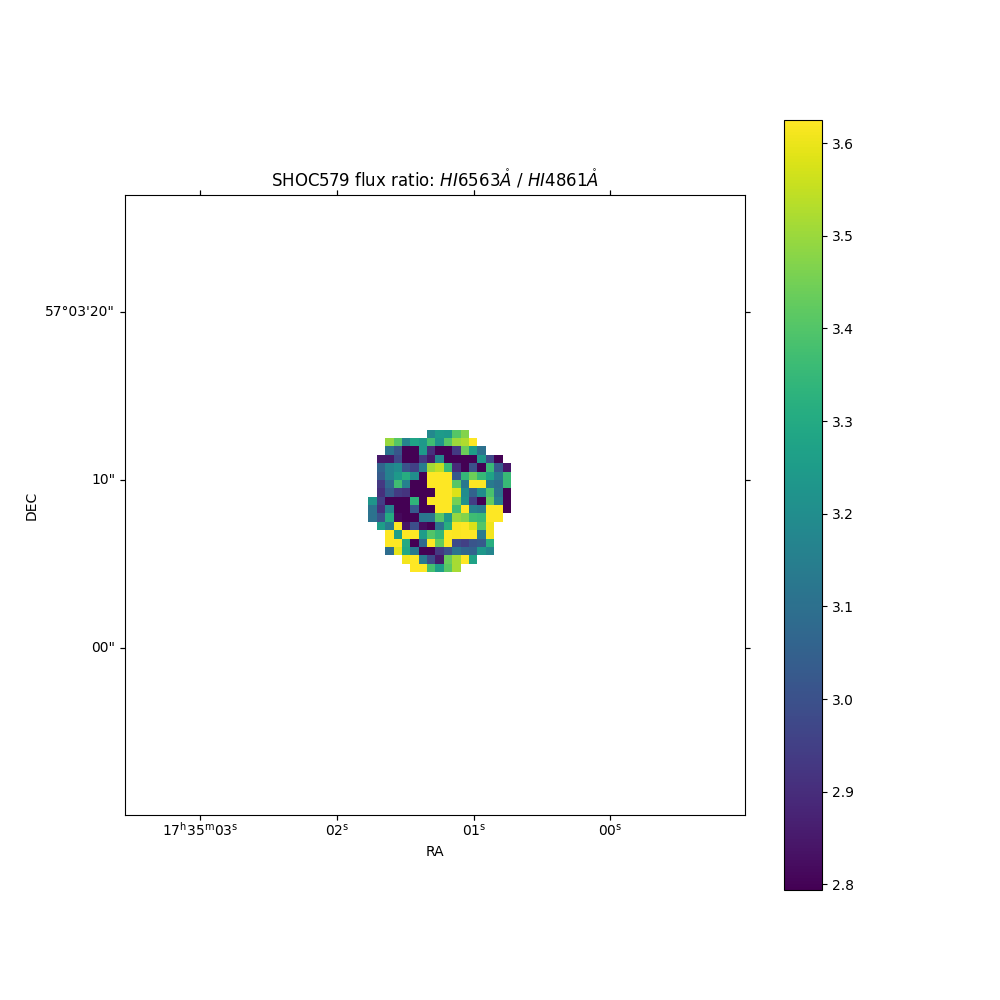

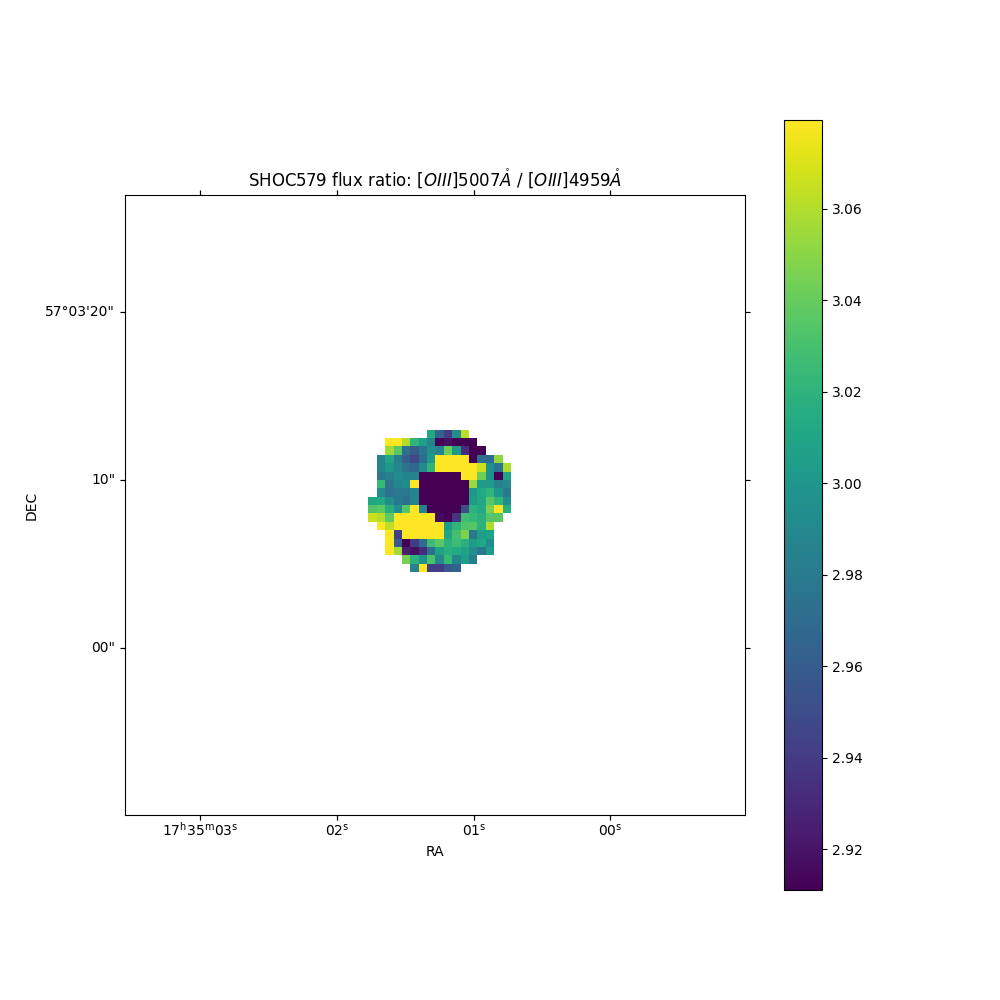

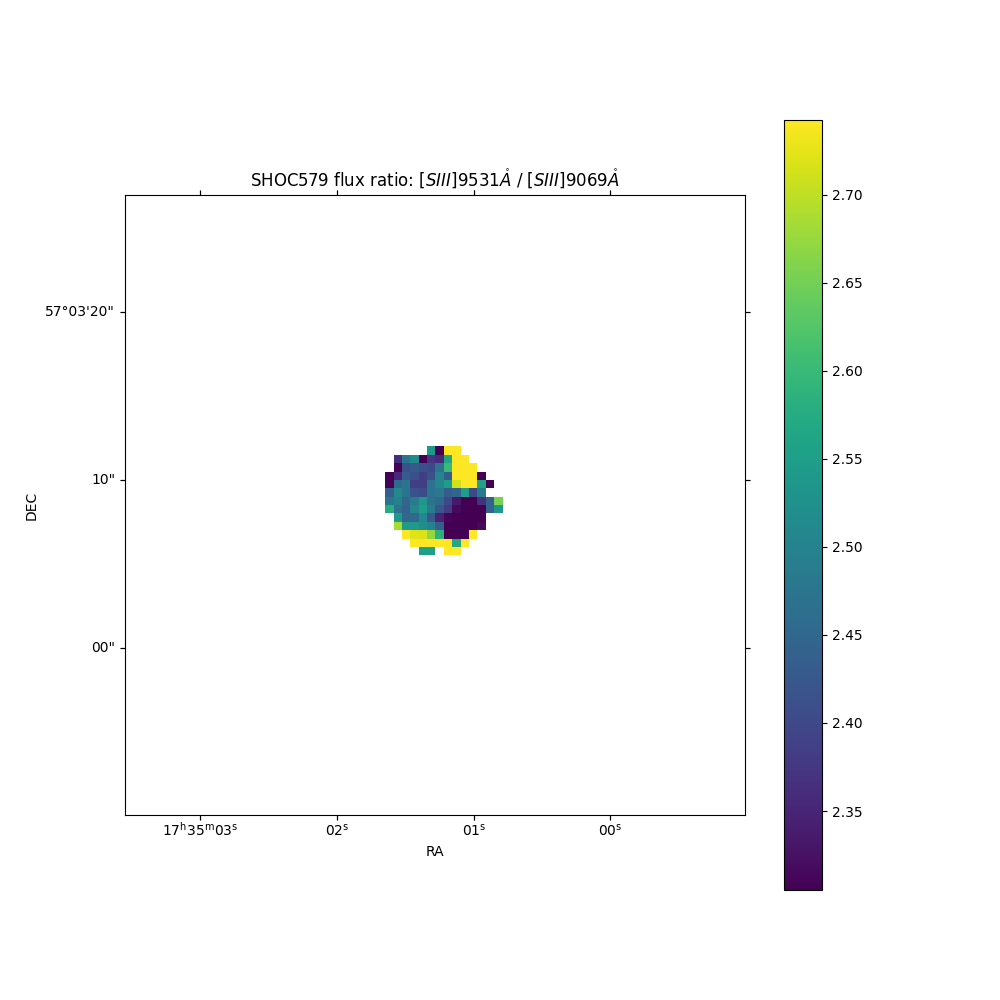

In [24]:
# Loop through the line ratios
for ion, lines in lines_ratio.items():

    # Recover the parameter measurements
    latex_array = lime.label_decomposition(lines, params_list=['latex_label'])[0]
    ratio_map = fits.getdata(fits_file, lines[0]) / fits.getdata(fits_file, lines[1])
    Halpha = fits.getdata(fits_file, lines[0])
    Hbeta = fits.getdata(fits_file, lines[1])

    # Get the astronomical coordinates from one of the headers of the lines log
    hdr = fits.getheader(fits_file, lines[0])
    wcs_maps = WCS(hdr)

    # Create the plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection=wcs_maps, slices=('x', 'y'))
    im = ax.imshow(ratio_map, vmin=np.nanpercentile(ratio_map, 16), vmax=np.nanpercentile(ratio_map, 84))
    cbar = fig.colorbar(im, ax=ax)
    ax.update({'title': f'SHOC579 flux ratio: {latex_array[0]} / {latex_array[1]}', 'xlabel': r'RA', 'ylabel': r'DEC'})
    plt.show()

From these plots we can draw the following conclusions:

* The $\frac{H\alpha}{H\beta}$ provides a characterisation of the extinction on the SHOC579. This ratio should be
  above around 2.98, the theoretical emissivity ratio for these lines which is weakly dependant on the physical conditions (temperature and density). However, it seems some pixels have aprubt changes: Can the higher values be only explain by the dust extinction? In the region 1, we didn't include the wide component of $H\alpha$. Does the ratio improve if we include this profile on the fitting for this region?

* The $\frac{[OIII]5007Å}{[OIII]4959Å}$ ratio should remain constant around 3 independently of the physical
  conditions. In general we observe very close values over the threee masks. What happens if we consider the integrated flux instead of the profile (Gaussian flux). Could it be that this line is too intense and therefore the CCD measurement lies outside the linearity region?

* The $\frac{[SIII]9531Å}{[SIII]9069Å}$ ratio should remain constant around 2.47 independently of the physical
  conditions. This seems to be the case for most of the galaxy. In some spaxels, however, the value seems to be lower/higher.
  Could this be explained by the telluric features in the proximity of the lines which could be harder to correct as the emission feature strength becomes weaker? It may be necesarry to inspect these spaxels individually to confirm the if one or both lines are heavily contaminated.

As you may have noticed, at this point we are starting to derive scientific conclusions from the data. In any implementation
of $LiMe$, the user is encouraged to review every step to confirm that the measurements agree with the expected results.
